<a href="https://colab.research.google.com/github/xolotl18/Homework2-Caltech101/blob/master/Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from copy import deepcopy
import numpy as np

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256    # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 40      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomHorizontalFlip(),# Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),
                                      transforms.RandomGrayscale(),   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225)),# Normalizes tensor with mean and standard deviation of ImageNet 
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))                                    
])

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/xolotl18/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)


train_indexes, val_indexes =  train_dataset.train_val_split(val_size=0.5)# split the indices for your train and val split

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


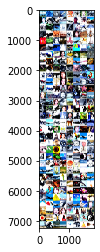

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(val_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

**Prepare Network**

In [ ]:
#net = alexnet() # Loading AlexNet model
#net = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

in_features = net.fc.in_features
net.fc = nn.Linear(in_features, NUM_CLASSES)
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

'''#freeze the last layer
for param in net.classifier.parameters():
  param.requires_grad = False

#freeze the convolutional layers by freezing the whole network and then unfreezing the last layer
for param in net.parameters():
  param.requires_grad = False

for param in net.classifier.parameters():
  param.requires_grad = True'''


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


'#freeze the last layer\nfor param in net.classifier.parameters():\n  param.requires_grad = False\n\n#freeze the convolutional layers by freezing the whole network and then unfreezing the last layer\nfor param in net.parameters():\n  param.requires_grad = False\n\nfor param in net.classifier.parameters():\n  param.requires_grad = True'

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

best_loss = 500
best_net = net

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

  #net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  loss_tot = 0
  with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      
      loss = criterion(outputs, labels)
      
      loss_tot += loss.item()
  
  loss = loss_tot / len(val_dataloader)

  #select the best performing model based on the loss computed on the evaluation set
  #the best state of the network is the one with the lowest loss on the evaluation set

  if loss <= best_loss:
    best_net = net
    best_loss = loss

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  print()
  print('Validation Accuracy: {}'.format(accuracy))
  print('Validation Loss: {}'.format(loss))
  print('Best Loss: {}'.format(best_loss))


Starting epoch 1/40, LR = [0.01]
Step 0, Loss 4.882737159729004
Step 10, Loss 3.049043893814087


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Validation Accuracy: 0.3367911479944675
Validation Loss: 2.881966849168142
Best Loss: 2.881966849168142
Starting epoch 2/40, LR = [0.01]


Step 20, Loss 2.1882784366607666


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.6113416320885201
Validation Loss: 1.980404367049535
Best Loss: 1.980404367049535
Starting epoch 3/40, LR = [0.01]


Step 30, Loss 1.4506394863128662


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Validation Accuracy: 0.7354771784232366
Validation Loss: 1.3438303172588348
Best Loss: 1.3438303172588348
Starting epoch 4/40, LR = [0.01]


Step 40, Loss 0.8436172604560852


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.8364453665283541
Validation Loss: 0.9274731377760569
Best Loss: 0.9274731377760569
Starting epoch 5/40, LR = [0.01]


Step 50, Loss 0.5456655025482178


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.8744813278008299
Validation Loss: 0.7105595469474792
Best Loss: 0.7105595469474792
Starting epoch 6/40, LR = [0.01]


Step 60, Loss 0.3822445273399353


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Validation Accuracy: 0.896957123098202
Validation Loss: 0.5747109403212866
Best Loss: 0.5747109403212866
Starting epoch 7/40, LR = [0.01]


Step 70, Loss 0.2831636071205139


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Validation Accuracy: 0.9052558782849239
Validation Loss: 0.5052466789881388
Best Loss: 0.5052466789881388
Starting epoch 8/40, LR = [0.01]


Step 80, Loss 0.22127343714237213


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Validation Accuracy: 0.9073305670816044
Validation Loss: 0.4621783097585042
Best Loss: 0.4621783097585042
Starting epoch 9/40, LR = [0.01]


Step 90, Loss 0.17040053009986877


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9121715076071922
Validation Loss: 0.433255173265934
Best Loss: 0.433255173265934
Starting epoch 10/40, LR = [0.01]


Step 100, Loss 0.1207650899887085


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Validation Accuracy: 0.9190871369294605
Validation Loss: 0.4064384698867798
Best Loss: 0.4064384698867798
Starting epoch 11/40, LR = [0.01]


Step 110, Loss 0.10034795105457306


  0%|          | 0/12 [00:00<?, ?it/s]

Step 120, Loss 0.10556083917617798


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9177040110650069
Validation Loss: 0.38680045555035275
Best Loss: 0.38680045555035275
Starting epoch 12/40, LR = [0.01]


Step 130, Loss 0.06869088858366013


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9156293222683264
Validation Loss: 0.3872762843966484
Best Loss: 0.38680045555035275
Starting epoch 13/40, LR = [0.01]


Step 140, Loss 0.059986189007759094


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Validation Accuracy: 0.9159751037344398
Validation Loss: 0.37524916728337604
Best Loss: 0.37524916728337604
Starting epoch 14/40, LR = [0.01]


Step 150, Loss 0.07506844401359558


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9208160442600276
Validation Loss: 0.36342233171065647
Best Loss: 0.36342233171065647
Starting epoch 15/40, LR = [0.01]


Step 160, Loss 0.04586396366357803


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.9173582295988935
Validation Loss: 0.3578299954533577
Best Loss: 0.3578299954533577
Starting epoch 16/40, LR = [0.01]


Step 170, Loss 0.062042973935604095


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9190871369294605
Validation Loss: 0.35597194234530133
Best Loss: 0.35597194234530133
Starting epoch 17/40, LR = [0.01]


Step 180, Loss 0.03720111399888992


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9201244813278008
Validation Loss: 0.35095781832933426
Best Loss: 0.35095781832933426
Starting epoch 18/40, LR = [0.01]


Step 190, Loss 0.0354447215795517


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.923582295988935
Validation Loss: 0.33843563745419186
Best Loss: 0.33843563745419186
Starting epoch 19/40, LR = [0.01]


Step 200, Loss 0.03460940718650818


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Validation Accuracy: 0.9228907330567082
Validation Loss: 0.32914265245199203
Best Loss: 0.32914265245199203
Starting epoch 20/40, LR = [0.01]


Step 210, Loss 0.027001528069376945


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Validation Accuracy: 0.91701244813278
Validation Loss: 0.3289356033007304
Best Loss: 0.3289356033007304
Starting epoch 21/40, LR = [0.0001]


Step 220, Loss 0.028543809428811073


  0%|          | 0/12 [00:00<?, ?it/s]

Step 230, Loss 0.02378835715353489


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Validation Accuracy: 0.9215076071922544
Validation Loss: 0.3253210534652074
Best Loss: 0.3253210534652074
Starting epoch 22/40, LR = [0.001]


Step 240, Loss 0.023950690403580666


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.9208160442600276
Validation Loss: 0.32888006418943405
Best Loss: 0.3253210534652074
Starting epoch 23/40, LR = [0.001]


Step 250, Loss 0.032451823353767395


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.923582295988935
Validation Loss: 0.3288295219341914
Best Loss: 0.3253210534652074
Starting epoch 24/40, LR = [0.001]


Step 260, Loss 0.03221642225980759


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.9201244813278008
Validation Loss: 0.3293669993678729
Best Loss: 0.3253210534652074
Starting epoch 25/40, LR = [0.001]


Step 270, Loss 0.02952958643436432


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Validation Accuracy: 0.9270401106500692
Validation Loss: 0.32667768994967145
Best Loss: 0.3253210534652074
Starting epoch 26/40, LR = [0.001]


Step 280, Loss 0.04230930656194687


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9242738589211619
Validation Loss: 0.32307980706294376
Best Loss: 0.32307980706294376
Starting epoch 27/40, LR = [0.001]


Step 290, Loss 0.031055152416229248


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Validation Accuracy: 0.9253112033195021
Validation Loss: 0.3193170875310898
Best Loss: 0.3193170875310898
Starting epoch 28/40, LR = [0.001]


Step 300, Loss 0.022945670410990715


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.9221991701244814
Validation Loss: 0.32494423538446426
Best Loss: 0.3193170875310898
Starting epoch 29/40, LR = [0.001]


Step 310, Loss 0.02678178809583187


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Validation Accuracy: 0.9163208852005532
Validation Loss: 0.32776961475610733
Best Loss: 0.3193170875310898
Starting epoch 30/40, LR = [0.001]


Step 320, Loss 0.02766072005033493


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.9242738589211619
Validation Loss: 0.3254608064889908
Best Loss: 0.3193170875310898
Starting epoch 31/40, LR = [0.001]


Step 330, Loss 0.022708067670464516


  0%|          | 0/12 [00:00<?, ?it/s]

Step 340, Loss 0.022861821576952934


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.921161825726141
Validation Loss: 0.32650025685628253
Best Loss: 0.3193170875310898
Starting epoch 32/40, LR = [0.001]


Step 350, Loss 0.023175127804279327


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9249654218533887
Validation Loss: 0.318148414293925
Best Loss: 0.318148414293925
Starting epoch 33/40, LR = [0.001]


Step 360, Loss 0.029713863506913185


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9208160442600276
Validation Loss: 0.3269301801919937
Best Loss: 0.318148414293925
Starting epoch 34/40, LR = [0.001]


Step 370, Loss 0.026899630203843117


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Validation Accuracy: 0.9201244813278008
Validation Loss: 0.3226555859049161
Best Loss: 0.318148414293925
Starting epoch 35/40, LR = [0.001]


Step 380, Loss 0.02085326984524727


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Validation Accuracy: 0.9253112033195021
Validation Loss: 0.32061342398325604
Best Loss: 0.318148414293925
Starting epoch 36/40, LR = [0.001]


Step 390, Loss 0.02724330686032772


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.9266943291839558
Validation Loss: 0.3204858675599098
Best Loss: 0.318148414293925
Starting epoch 37/40, LR = [0.001]


Step 400, Loss 0.024965405464172363


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.923582295988935
Validation Loss: 0.32397233694791794
Best Loss: 0.318148414293925
Starting epoch 38/40, LR = [0.001]


Step 410, Loss 0.030469384044408798


100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Validation Accuracy: 0.9221991701244814
Validation Loss: 0.32409030944108963
Best Loss: 0.318148414293925
Starting epoch 39/40, LR = [0.001]


Step 420, Loss 0.02529737539589405


100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Validation Accuracy: 0.9249654218533887
Validation Loss: 0.3228563889861107
Best Loss: 0.318148414293925
Starting epoch 40/40, LR = [0.001]


Step 430, Loss 0.0243244469165802


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Accuracy: 0.9221991701244814
Validation Loss: 0.32064573963483173
Best Loss: 0.318148414293925


**Validation**

In [ ]:
PATH = './resnet.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
PATH = './resnet.pth'

**Test**

In [ ]:
#net = best_net # this will bring the network to GPU if DEVICE is cuda
net.load_state_dict(torch.load(PATH))
net = net.to(DEVICE)
net.train(False) # Set Network to evaluation mode

running_corrects = 0
with torch.no_grad():
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print()
print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Test Accuracy: 0.926374006221915
